# Blok 2 - _*Pipelines*_

### - Feature Selection
### - Pipelines
### - GridSearch / Hyper Parameter Selection
### - Cross Validation
### - Random Forest
### - XGBoost
---

# Feature Selection

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("dark_background")


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine

wine_data = load_wine()
wine_df = pd.DataFrame(
    data=wine_data.data, 
    columns=wine_data.feature_names)
wine_df['target'] = wine_data.target

In [3]:
wine_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [4]:
from sklearn.model_selection import train_test_split

X = wine_df.drop(['target'], axis=1)
y = wine_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    shuffle=True, 
                                                    stratify=y)


### - `shuffle` - dane mają być losowo "potasowane"
### - `stratify`  - poszczególne klasy mają być reprezentowane proporcjonalnie w zbiorze testowym


In [5]:
X_train.var(axis=0)

alcohol                             0.682379
malic_acid                          1.317490
ash                                 0.082686
alcalinity_of_ash                  10.682761
magnesium                         185.972922
total_phenols                       0.371650
flavanoids                          0.990724
nonflavanoid_phenols                0.015593
proanthocyanins                     0.323196
color_intensity                     5.875679
hue                                 0.056031
od280/od315_of_diluted_wines        0.529107
proline                         91871.296092
dtype: float64

In [6]:
from sklearn.preprocessing import Normalizer
norm = Normalizer().fit(X_train)
norm_X_train = norm.transform(X_train)
norm_X_train.var(axis=0)

array([4.85442547e-05, 6.66273648e-06, 1.72822367e-06, 1.84885640e-04,
       2.58870034e-03, 2.31924673e-06, 3.27935332e-06, 9.23256423e-08,
       1.45432451e-06, 1.71122212e-05, 5.44956065e-07, 3.56385672e-06,
       8.67247784e-05])

### Eliminacja kolumn o niskiej zmienności

In [7]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold = 1e-6)
selected_features = selector.fit_transform(norm_X_train)
selected_features.shape

(124, 11)

## "Ręczne" zrzucanie kolumn

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)

preds = dt.predict(X_test)
f1_score_all = round(f1_score(y_test, preds, average='weighted'),3)
print(f1_score_all)

X_train_sel = X_train.drop(['hue', 'nonflavanoid_phenols'], axis=1)
X_test_sel = X_test.drop(['hue', 'nonflavanoid_phenols'], axis=1)
dt.fit(X_train_sel, y_train)
preds_sel = dt.predict(X_test_sel)
f1_score_sel = round(f1_score(y_test, preds_sel, average='weighted'), 3)
f1_score_sel

0.851


0.87

## Zrzucanie kolumn testem $\chi^2$

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
f1_score_list = []
for k in range(1, 14):
    selector = SelectKBest(chi2, k=k)
    selector.fit(X_train_v2, y_train_v2)
    
    sel_X_train_v2 = selector.transform(X_train_v2)
    sel_X_test_v2 = selector.transform(X_test_v2)
    
    dt.fit(sel_X_train_v2, y_train_v2)
    kbest_preds = dt.predict(sel_X_test_v2)
    f1_score_kbest = round(f1_score(y_test, kbest_preds, average='weighted'), 3)
    f1_score_list.append(f1_score_kbest)

print(f1_score_list)

[0.625, 0.926, 0.906, 0.908, 0.87, 0.87, 0.87, 0.87, 0.89, 0.851, 0.908, 0.908, 0.851]


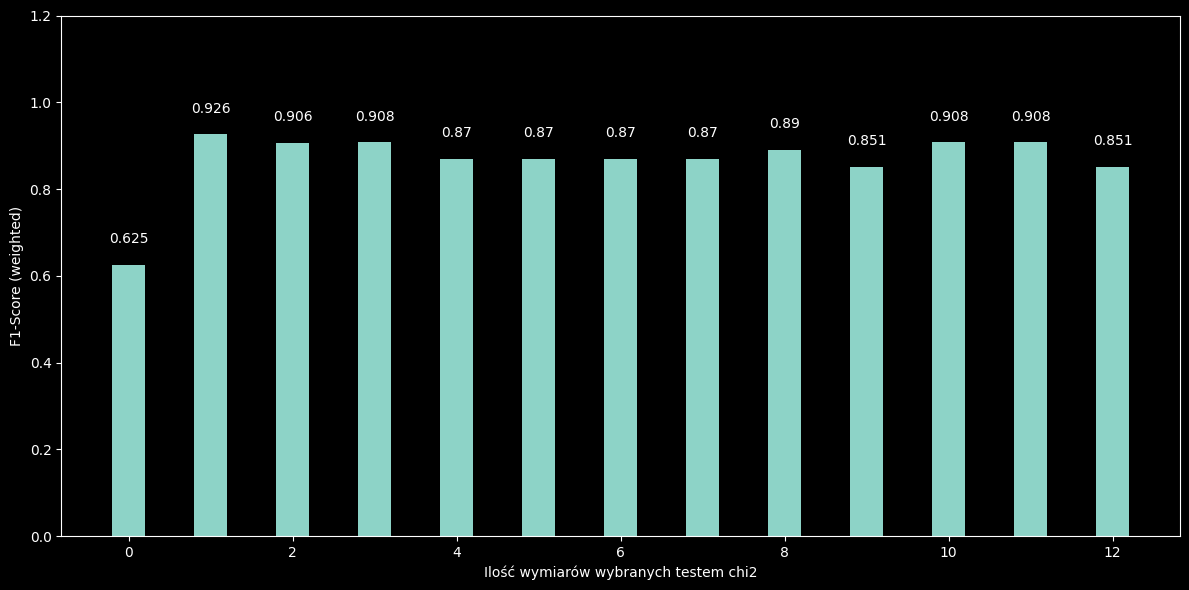

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
x = list(range(0,13))
y = f1_score_list
ax.bar(x, y, width=0.4)
ax.set_xlabel('Ilość wymiarów wybranych testem chi2')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')
    
plt.tight_layout()

## Recursive Feature Elimination

### - korzystając z osobnego estymatora posiadającego `coef_` lub `feature_importance_` iteracyjnie odrzucane są kolejne wagi

In [11]:
from sklearn.feature_selection import RFE

X_train_v3, X_test_v3, y_train_v3, y_test_v3 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
RFE_selector = RFE(estimator=dt, n_features_to_select=4, step=1)
RFE_selector.fit(X_train_v3, y_train_v3)

RFE(estimator=DecisionTreeClassifier(random_state=42), n_features_to_select=4)

In [12]:
X_train_v3.columns[RFE_selector.support_]

Index(['flavanoids', 'color_intensity', 'hue', 'proline'], dtype='object')

In [13]:
sel_X_train_v3 = RFE_selector.transform(X_train_v3)
sel_X_test_v3 = RFE_selector.transform(X_test_v3)
dt.fit(sel_X_train_v3, y_train_v3)
RFE_preds = dt.predict(sel_X_test_v3)
rfe_f1_score = round(f1_score(y_test_v3, RFE_preds, average='weighted'),3)
print(rfe_f1_score)

0.89


## Select from model

### - korzystając z osobnego estymatora posiadającego `coef_` lub `feature_importance_` 

In [14]:
from sklearn.feature_selection import SelectFromModel

X_train_v4, X_test_v4, y_train_v4, y_test_v4 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

sfm_selector = SelectFromModel(estimator=DecisionTreeClassifier())
sfm_selector.fit(X_train_v4,  y_train_v4)

SelectFromModel(estimator=DecisionTreeClassifier())

In [15]:
X_train_v4.columns[sfm_selector.get_support()]

Index(['total_phenols', 'color_intensity', 'proline'], dtype='object')

In [16]:
sel_X_train_v4 = sfm_selector.transform(X_train_v4)
sel_X_test_v4 = sfm_selector.transform(X_test_v4)

dt.fit(sel_X_train_v4, y_train_v4)
sfm_preds = dt.predict(sel_X_test_v4)
sfm_f1_score = round(f1_score(y_test_v4, sfm_preds, average='weighted'),3)
print(rfe_f1_score)

0.89


---

# Pipeline

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

ppln_clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC())),
  ('classification', DecisionTreeClassifier())
])
ppln_clf.fit(X_train, y_train)

Pipeline(steps=[('feature_selection', SelectFromModel(estimator=LinearSVC())),
                ('classification', DecisionTreeClassifier())])

In [30]:
ppln_preds = ppln_clf.predict(X_test)
ppln_f1_score = round(f1_score(y_test, ppln_preds, average='weighted'),3)
ppln_f1_score

0.925

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

ppln_clf = Pipeline([
  ('feature_selection', SelectKBest(chi2, k=4)),
  ('classification', DecisionTreeClassifier())
])
ppln_clf.fit(X_train, y_train)

Pipeline(steps=[('feature_selection',
                 SelectKBest(k=4,
                             score_func=<function chi2 at 0x000001F421DC19D0>)),
                ('classification', DecisionTreeClassifier())])

In [32]:
ppln_preds = ppln_clf.predict(X_test)
ppln_f1_score = round(f1_score(y_test, ppln_preds, average='weighted'),3)
ppln_f1_score

0.89

---

In [34]:
import pandas as pd

data = pd.read_csv('data/adverts_29_04.csv', sep=';')
data['cena_za_metr'] = data['Cena'] / data['Wielkość (m2)']
data = data.dropna(subset=['cena_za_metr'])
df = data.drop(['Cena', 'Data dodania'], axis=1)
df

,Lokalizacja,Na sprzedaż przez,Rodzaj nieruchomości,Liczba pokoi,Liczba łazienek,Wielkość (m2),opis,Parking,cena_za_metr
0,"Praga Północ, Warszawa",Właściciel,Mieszkanie,4 pokoje,1 łazienka,50.0,CO] - gotowiec inwestycyjny KUP I ZARABIAJ \n\...,NaN,10380.000000
1,"Wilanów, Warszawa",Właściciel,Mieszkanie,2 pokoje,1 łazienka,53.0,Sprzedam mieszkanie 2 pokoje 53m2 w\r\nMiastec...,Ulica,11679.245283
2,"Wilanów, Warszawa",Właściciel,Mieszkanie,3 pokoje,2 łazienki,90.0,Sprzedam komfortowo urządzone mieszkanie o pow...,Garaż,10555.555556
3,"Śródmieście, Warszawa",Agencja,Mieszkanie,2 pokoje,NaN,55.0,Agencja WN pracuje podczas pandemii. Prowadzim...,Brak,11909.090909
4,"Wola, Warszawa",Agencja,Mieszkanie,2 pokoje,1 łazienka,45.0,"BLISKA WOLA , komfortowy 2- pokojowy apartamen...",NaN,12805.511111
...,...,...,...,...,...,...,...,...,...
982,"Bemowo, Warszawa",Agencja,Mieszkanie,3 pokoje,NaN,74.0,Mieszkanie Bemowo przy budowanym metrze\n\nNa ...,NaN,9445.945946
983,"Mokotów, Warszawa",Agencja,Mieszkanie,3 pokoje,NaN,66.0,"Blok z wielkiej płyty z roku 1992, PO REMONCIE...",NaN,9772.727273
984,"Wawer, Warszawa",Agencja,Dom,4 pokoje,NaN,160.0,Na sprzedaż nowoczesny dom 4-pokojowy w zabud...,NaN,8625.000000
985,"Bemowo, Warszawa",Agencja,Mieszkanie,3 pokoje,NaN,73.0,Na sprzedaż mieszkanie w apartamentowcu wybud...,NaN,7794.520548


In [35]:
dum_df = pd.get_dummies(df, columns=['Lokalizacja', 'Na sprzedaż przez', 'Rodzaj nieruchomości', 'Liczba pokoi', 'Liczba łazienek', 'Parking'])
dum_df

,Wielkość (m2),opis,cena_za_metr,"Lokalizacja_Bemowo, Warszawa","Lokalizacja_Białołęka, Warszawa","Lokalizacja_Bielany, Warszawa","Lokalizacja_Mokotów, Warszawa","Lokalizacja_Ochota, Warszawa","Lokalizacja_Praga Południe, Warszawa","Lokalizacja_Praga Północ, Warszawa",...,Liczba pokoi_6 lub więcej pokoi,Liczba pokoi_Kawalerka lub garsoniera,Liczba łazienek_1 łazienka,Liczba łazienek_2 łazienki,Liczba łazienek_3 łazienki,Liczba łazienek_4 lub więcej łazienek,Parking_Brak,Parking_Garaż,Parking_Kryty,Parking_Ulica
0,50.0,CO] - gotowiec inwestycyjny KUP I ZARABIAJ \n\...,10380.000000,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,53.0,Sprzedam mieszkanie 2 pokoje 53m2 w\r\nMiastec...,11679.245283,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,90.0,Sprzedam komfortowo urządzone mieszkanie o pow...,10555.555556,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,55.0,Agencja WN pracuje podczas pandemii. Prowadzim...,11909.090909,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,45.0,"BLISKA WOLA , komfortowy 2- pokojowy apartamen...",12805.511111,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,74.0,Mieszkanie Bemowo przy budowanym metrze\n\nNa ...,9445.945946,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
983,66.0,"Blok z wielkiej płyty z roku 1992, PO REMONCIE...",9772.727273,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
984,160.0,Na sprzedaż nowoczesny dom 4-pokojowy w zabud...,8625.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
985,73.0,Na sprzedaż mieszkanie w apartamentowcu wybud...,7794.520548,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
dum_df.columns

Index(['Wielkość (m2)', 'opis', 'cena_za_metr', 'Lokalizacja_Bemowo, Warszawa',
       'Lokalizacja_Białołęka, Warszawa', 'Lokalizacja_Bielany, Warszawa',
       'Lokalizacja_Mokotów, Warszawa', 'Lokalizacja_Ochota, Warszawa',
       'Lokalizacja_Praga Południe, Warszawa',
       'Lokalizacja_Praga Północ, Warszawa', 'Lokalizacja_Rembertów, Warszawa',
       'Lokalizacja_Targówek, Warszawa', 'Lokalizacja_Ursus, Warszawa',
       'Lokalizacja_Ursynów, Warszawa', 'Lokalizacja_Wawer, Warszawa',
       'Lokalizacja_Wesoła, Warszawa', 'Lokalizacja_Wilanów, Warszawa',
       'Lokalizacja_Wola, Warszawa', 'Lokalizacja_Włochy, Warszawa',
       'Lokalizacja_Śródmieście, Warszawa', 'Lokalizacja_Żoliborz, Warszawa',
       'Na sprzedaż przez_Agencja', 'Na sprzedaż przez_Właściciel',
       'Rodzaj nieruchomości_Dom', 'Rodzaj nieruchomości_Inne',
       'Rodzaj nieruchomości_Mieszkanie', 'Liczba pokoi_2 pokoje',
       'Liczba pokoi_3 pokoje', 'Liczba pokoi_4 pokoje',
       'Liczba pokoi_5 pokoi

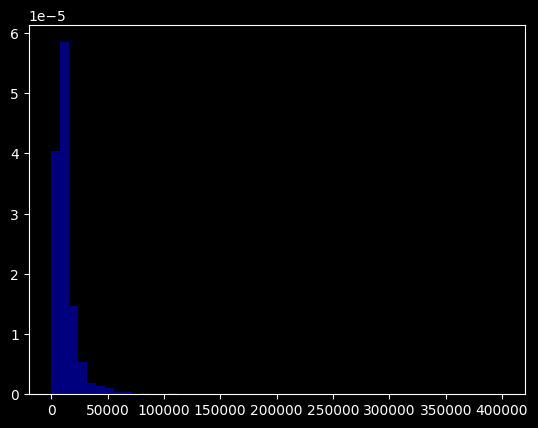

In [37]:
import matplotlib.pyplot as plt

plt.hist(dum_df['cena_za_metr'], 50,
         density=True,
         histtype='bar',
         facecolor='b',
         alpha=0.5)

plt.show()

In [38]:
dum_df.drop(dum_df[dum_df.cena_za_metr >30000.0].index, inplace=True)

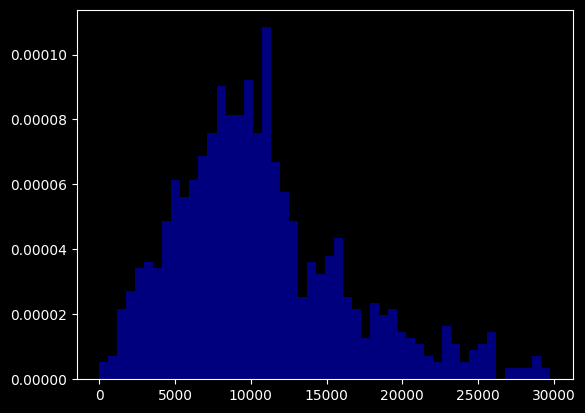

In [39]:
import matplotlib.pyplot as plt

plt.hist(dum_df['cena_za_metr'], 50,
         density=True,
         histtype='bar',
         facecolor='b',
         alpha=0.5)

plt.show()

In [40]:
dum_df.corr()['cena_za_metr']

Wielkość (m2)                           -0.064497
cena_za_metr                             1.000000
Lokalizacja_Bemowo, Warszawa            -0.018889
Lokalizacja_Białołęka, Warszawa         -0.159826
Lokalizacja_Bielany, Warszawa            0.003766
Lokalizacja_Mokotów, Warszawa            0.131210
Lokalizacja_Ochota, Warszawa            -0.018932
Lokalizacja_Praga Południe, Warszawa     0.002441
Lokalizacja_Praga Północ, Warszawa       0.021179
Lokalizacja_Rembertów, Warszawa         -0.100811
Lokalizacja_Targówek, Warszawa          -0.036512
Lokalizacja_Ursus, Warszawa             -0.074461
Lokalizacja_Ursynów, Warszawa           -0.062382
Lokalizacja_Wawer, Warszawa             -0.141669
Lokalizacja_Wesoła, Warszawa            -0.151450
Lokalizacja_Wilanów, Warszawa           -0.085052
Lokalizacja_Wola, Warszawa               0.055272
Lokalizacja_Włochy, Warszawa            -0.031444
Lokalizacja_Śródmieście, Warszawa        0.323234
Lokalizacja_Żoliborz, Warszawa           0.045081


## Mapa ciepła korelacji parametrów

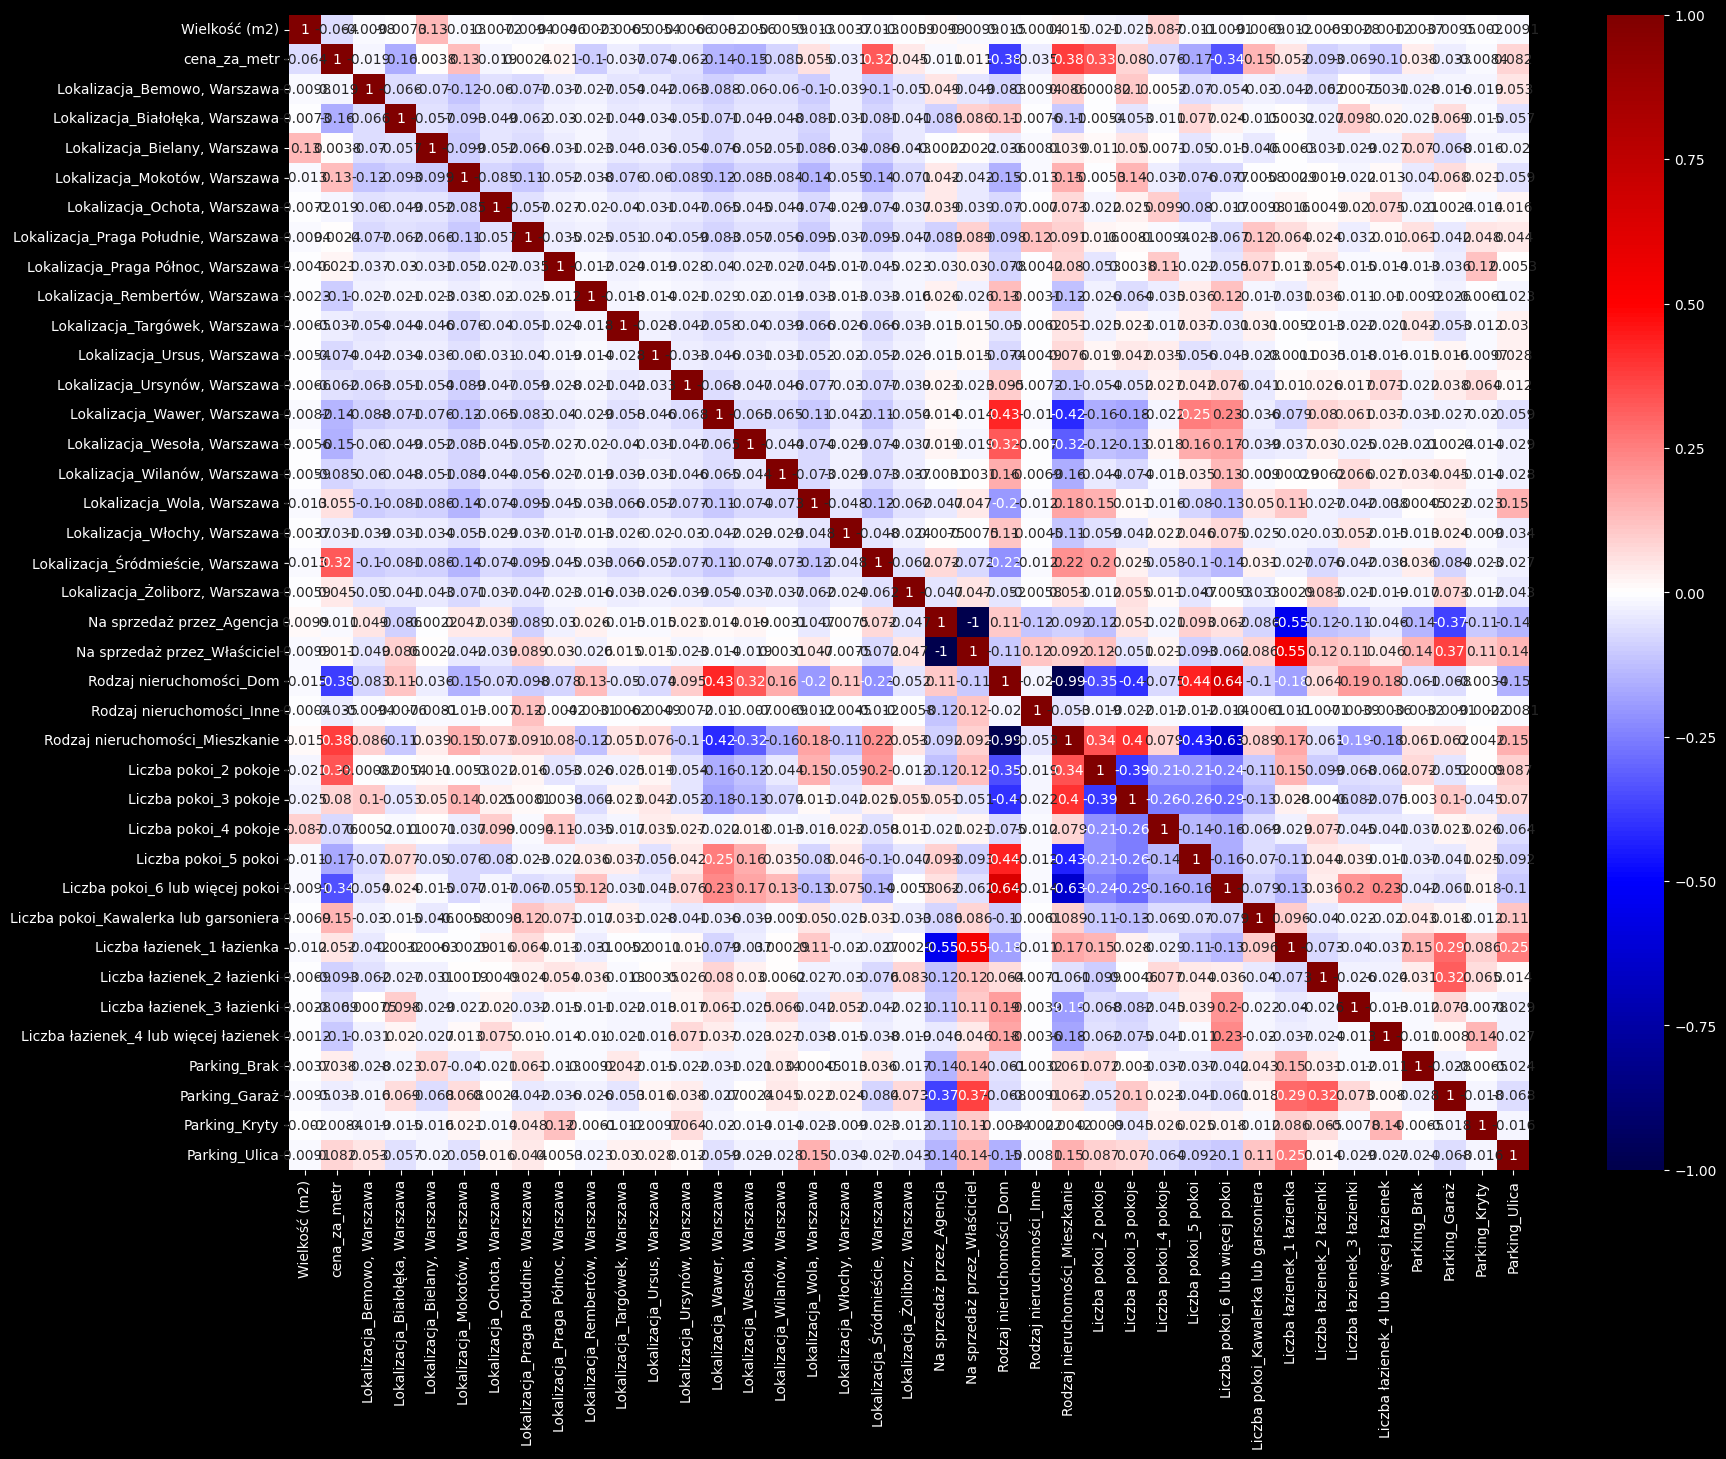

In [41]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(20,15))
plt.style.use("dark_background")

sns.heatmap(dum_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

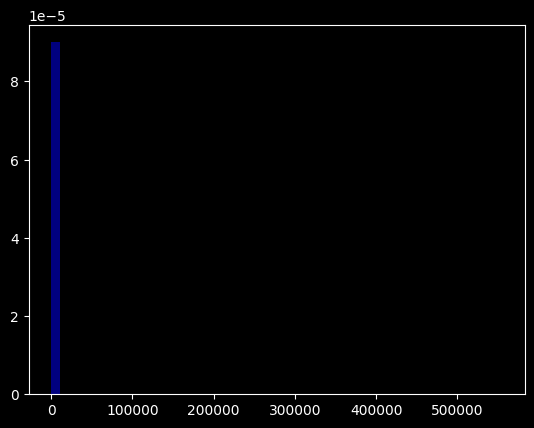

In [42]:
plt.hist(dum_df['Wielkość (m2)'], 50,
         density=True,
         histtype='bar',
         facecolor='b',
         alpha=0.5)

plt.show()

In [43]:
dum_df.drop(dum_df[dum_df['Wielkość (m2)'] >300.0].index, inplace=True)
dum_df

,Wielkość (m2),opis,cena_za_metr,"Lokalizacja_Bemowo, Warszawa","Lokalizacja_Białołęka, Warszawa","Lokalizacja_Bielany, Warszawa","Lokalizacja_Mokotów, Warszawa","Lokalizacja_Ochota, Warszawa","Lokalizacja_Praga Południe, Warszawa","Lokalizacja_Praga Północ, Warszawa",...,Liczba pokoi_6 lub więcej pokoi,Liczba pokoi_Kawalerka lub garsoniera,Liczba łazienek_1 łazienka,Liczba łazienek_2 łazienki,Liczba łazienek_3 łazienki,Liczba łazienek_4 lub więcej łazienek,Parking_Brak,Parking_Garaż,Parking_Kryty,Parking_Ulica
0,50.0,CO] - gotowiec inwestycyjny KUP I ZARABIAJ \n\...,10380.000000,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,53.0,Sprzedam mieszkanie 2 pokoje 53m2 w\r\nMiastec...,11679.245283,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,90.0,Sprzedam komfortowo urządzone mieszkanie o pow...,10555.555556,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,55.0,Agencja WN pracuje podczas pandemii. Prowadzim...,11909.090909,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,45.0,"BLISKA WOLA , komfortowy 2- pokojowy apartamen...",12805.511111,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,74.0,Mieszkanie Bemowo przy budowanym metrze\n\nNa ...,9445.945946,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
983,66.0,"Blok z wielkiej płyty z roku 1992, PO REMONCIE...",9772.727273,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
984,160.0,Na sprzedaż nowoczesny dom 4-pokojowy w zabud...,8625.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
985,73.0,Na sprzedaż mieszkanie w apartamentowcu wybud...,7794.520548,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---
# Regresja

In [44]:
from sklearn.linear_model import LinearRegression

y = dum_df['cena_za_metr']
X = dum_df.drop(['opis', 'cena_za_metr'], axis=1)

reg = LinearRegression().fit(X, y)

In [45]:
reg.score(X, y)

0.3296082989738536

# $R^2$

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17)https://en.wikipedia.org/wiki/Coefficient_of_determination

Współczynnik determinacji - Jaka część wariancji zmiennej objaśnianej jest pochodzi od zmiennych tłumaczących

- 1.0 - Idealnie dopasowania
- 0.0 - Funkcja stała
- ... ale może być i ujemna

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17)
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.39766665409217494

---
## Walidacja krzyżowa

![Walidacja krzyżowa](img\xvi.png)

https://scikit-learn.org/stable/modules/cross_validation.html

In [47]:
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17)
scores = cross_val_score(LinearRegression(), X_train, y_train, cv=10)
print(list(scores))
print()
print("Mean r^2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.17158512004468074, 0.4002464866817569, 0.2976342708945746, 0.043191642458778046, 0.17997914817010774, 0.27370651738767693, 0.32535378297502326, 0.32184280608500426, 0.30400936121495503, 0.1940600544236466]

Mean r^2: 0.25 (+/- 0.20)


## Zmiana techniki scoringu

In [37]:
from sklearn.metrics import mean_squared_error, make_scorer


scores = cross_val_score(LinearRegression(), X_train, y_train, scoring=make_scorer(mean_squared_error), cv=5)
print(list(scores))
print()
print("Mean square error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[20873390.527972087, 25559567.18934256, 25310897.709129546, 19026992.9808826, 22484301.02710871]

Mean square error: 22651029.89 (+/- 5048241.66)


## Zmiana regresora

In [38]:
from sklearn.svm import SVR

scores = cross_val_score(SVR(kernel='linear', C=1000), X_train, y_train, cv=5)
print(list(scores))
print()
print("Mean r^2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.23804952563512416, 0.2115884023493967, 0.20975205178843537, 0.33793253114553534, 0.22722899401284613]

Mean r^2: 0.24 (+/- 0.10)


In [39]:
from sklearn.svm import SVR

scores = cross_val_score(SVR(kernel='linear', C=10), X_train, y_train, cv=5)
print(list(scores))
print()
print("Mean r^2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.11585022630497432, 0.08089523899355822, 0.09629758889017737, 0.2645327365125473, 0.14003899697306477]

Mean r^2: 0.14 (+/- 0.13)


In [40]:
from sklearn.svm import SVR

scores = cross_val_score(SVR(kernel='linear', C=100), X_train, y_train, cv=5)
print(list(scores))
print()
print("Mean r^2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.2116438428637396, 0.1695200172714666, 0.17937301707333064, 0.3370092359723945, 0.2106563510335382]

Mean r^2: 0.22 (+/- 0.12)


In [41]:
from sklearn.svm import SVR

scores = cross_val_score(SVR(kernel='rbf', C=1000), X_train, y_train, cv=5)
print(list(scores))
print()
print("Mean r^2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.0918468525567262, 0.052461127912378225, 0.045233257591872134, 0.2682718351774165, 0.12757846391295946]

Mean r^2: 0.12 (+/- 0.16)


In [42]:
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import SVR

scores = cross_val_score(GradientBoostingRegressor(), X_train, y_train, cv=10)
print(list(scores))
print()
print("Mean r^2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.0557682433120007, 0.33158584130362456, 0.17574889642388314, 0.05639395854378115, 0.19520132311655125, 0.27776180816481066, 0.43084344868064417, 0.22201474709874858, 0.26612434094694937, 0.1292226212614329]

Mean r^2: 0.21 (+/- 0.23)


## Hiperparametry
### `C` - współczynnik regularyzacji - odwrotność siły regularyzacji czyli __*"czynienia rozwiązania prostszym"*__


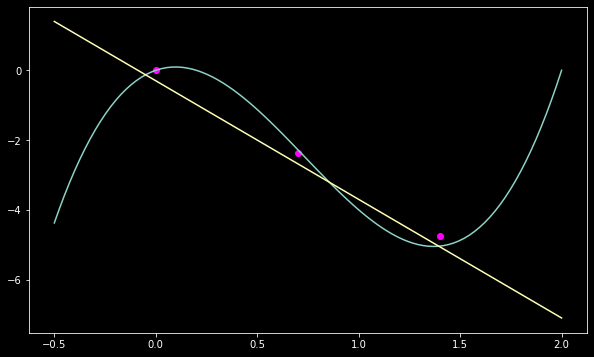

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("dark_background")
plt.figure(figsize=(10,6))
x = np.linspace(-0.5, 2, 100)
plt.plot(x, x*(5*x-1)*(x-2))
y = np.linspace(0, 1.4, 3)
plt.scatter(y, -3.4*y, color="#FF00FF");
z = np.linspace(-0.5, 2, 50)
plt.plot(z, -3.4*z-0.3);

## GridSearch elementów `Pipeline`

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from warnings import simplefilter
simplefilter(action='ignore', category=DeprecationWarning)

pipe = Pipeline([
    ('scale',  'passthrough'),
    ('regression', SVR())
])



In [45]:
pipe.set_params(regression__C=10)

Pipeline(steps=[('scale', 'passthrough'), ('regression', SVR(C=10))])

In [46]:
param_grid = dict(regression__C=[0.1, 1.0, 10, 100])

In [47]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipe, param_grid, verbose=1, cv=3)
grid_search

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale', 'passthrough'),
                                       ('regression', SVR(C=10))]),
             param_grid={'regression__C': [0.1, 1.0, 10, 100]}, verbose=1)

In [48]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale', 'passthrough'),
                                       ('regression', SVR(C=10))]),
             param_grid={'regression__C': [0.1, 1.0, 10, 100]}, verbose=1)

In [49]:
print(grid_search.best_estimator_)

Pipeline(steps=[('scale', 'passthrough'), ('regression', SVR(C=100))])


In [50]:
grid_search.best_score_

0.08283271578716715

## Scalers
- StandardScaler (standardyzacja - odejmuję średnia, dzieli przez wariancję)
- Normalizer (normalizacja - dzieli przez długość - sprowadza do wektora o normie 1)
- RobustScaler (odejmuje medianę i skaluje kwartylami)

In [51]:
from time import time

param_grid = dict( 
    scale=['passthrough', StandardScaler(), Normalizer()],
    regression__C=[ 10, 100],
    regression__kernel=['linear']
)
                  
print(param_grid)

###################################

grid_search = GridSearchCV(pipe, param_grid, verbose=1, cv=5, n_jobs=2)

###################################

t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()
print("Best parameters set:")
print(grid_search.best_estimator_)
print()
print(f"Best score: {grid_search.best_score_}")

{'scale': ['passthrough', StandardScaler(), Normalizer()], 'regression__C': [10, 100], 'regression__kernel': ['linear']}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
done in 1.572s

Best parameters set:
Pipeline(steps=[('scale', StandardScaler()),
                ('regression', SVR(C=100, kernel='linear'))])

Best score: 0.23654371487313064


- 5 - Walidacja krzyżowa
- 2 - parametry $C$
- 3 - scaler

$ 5 * 2 * 3 = 30 $ przebiegów

# Grid Strategies
- ## HalvingGridSearchCV
  - Przeszukiwanie przez podział binarny

- ## RandomizedSearchCV
  - W odróżnieniu do `GridSearchCV`, nie wszystkie parametry są sprawdzane, ale `n_iter` z pewnego rozkładu
  - Jeśli parametry są na liście - korzystamy z losowania bez zwracania 
  
- ## HalvingRandomSearchCV
  - Parametry są przeszukiwane losowo z coraz węższego zakresu
  
- ## <span style="color: cyan">auto-sklearn</span> 
  - używa nauczana maszynowego do wyboru algorytmu i dobrania hiperparametrów


---

# Pipeline dla tekstu

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer 

data = pd.read_csv('data/adverts_29_04.csv', sep=';')
data['cena_za_metr'] = data['Cena'] / data['Wielkość (m2)']
data = data.dropna(subset=['cena_za_metr'])
df = data.drop(['Cena', 'Data dodania'], axis=1)
df

tfidf = TfidfVectorizer()
tfs = tfidf.fit_transform(df["opis"])
tfs

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


pipeline = Pipeline([
                ('selector', ItemSelector(key='opis')),
                ('tfidf', TfidfVectorizer()),
                ('best', TruncatedSVD(n_components=250)),
                ('linear', LinearRegression())
            ])

y = dum_df['cena_za_metr']
X = dum_df.drop(['cena_za_metr'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
scores = cross_val_score(pipeline, X_train, y_train, cv=3)
print(list(scores))
print()
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from time import time
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

parameters = parameters = {
    'best__n_components': (250,),
    'svr__C': (100, 1000),
    'svr__kernel':('linear', 'rbf')
}

pipeline = Pipeline([
                ('selector', ItemSelector(key='opis')),
                ('tfidf', TfidfVectorizer()),
                ('best', TruncatedSVD()),
                ('svr', SVR())
            ])

grid_search = GridSearchCV(pipeline, parameters, verbose=1, cv=3, n_jobs=2)


y = dum_df['cena_za_metr']
X = dum_df.drop(['cena_za_metr'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17)

t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from operator import itemgetter

vectorizer = TfidfVectorizer(min_df=2)

X = vectorizer.fit_transform(X_train['opis'])



In [ ]:
import gzip
import sys
import re
import re

splitter = re.compile(r'[^ąąćęńłóóśśżżź\w]+')
isnumber = re.compile(r'[0-9]')

f = gzip.open('data/odm.txt.gz', 'rt', encoding='utf-8')
dictionary = {}
set_dict= set()

for x in f:
    t = x.strip().split(',')
    tt = [ x.strip().lower() for x in t]
    for w in tt:
        set_dict.add(w)
        dictionary[w]=tt[0]

def lematize(w):
    w = w.replace('ą','ą')
    w = w.replace('ó','ó')
    w = w.replace('ę','ę')
    w = w.replace('ż','ż')
    return dictionary.get(w,w)

opis1 = dum_df['opis'][0]



raw_corpus=[]
n=0

for i in dum_df.iterrows():
    n+=1
    l = list(splitter.split(i[1][1]))
    raw_corpus.append(l)

    
all_words = []
for t in raw_corpus:
    all_words[0:0] = t

words = {}
for w in all_words:
    rec = words.get(w.lower(), {'upper':0, 'lower': 0})
    if w.lower()==w or w.upper()==w:
        rec['lower'] = rec['lower'] +1
    else: 
        rec['upper'] = rec['upper'] +1
    words[w.lower()] = rec

raw_stop_words = [ x for x in words.keys() if words[x]['upper']>=words[x]['lower']*4 ]   

set_raw_stop_words = set(raw_stop_words)



In [ ]:
raw_stop_words[:20]

In [ ]:
def preprocessing(opis, filter_raw=True, filter_dict=True):
    opis = str(opis)
    tokenized = splitter.split(opis)
    l = list(tokenized)
    l = [ x.lower() for x in l ]
    l = [ x for x in l if len(x) > 2]
    l = [ x for x in l if x.find('_') < 0]
    l = [ x for x in l if isnumber.search(x) is None ]
    if filter_raw: l = [ x for x in l if x not in set_raw_stop_words ]
    if filter_dict: l = [ x for x in l if x in set_dict ]
    l = [ lematize(x) for x in l ]
    l = [ x for x in l if len(x) > 2]
    return l

In [ ]:
opis1

In [ ]:
print(preprocessing(opis1))

In [ ]:
print(preprocessing(opis1, filter_raw=False))

In [ ]:
print(preprocessing(opis1, filter_dict=False))

In [ ]:
print(preprocessing(opis1, filter_raw=False, filter_dict=False))

In [ ]:
dum_df["opisTT"] = dum_df["opis"].apply(lambda x: ' '.join(preprocessing(x,filter_raw=True, filter_dict=True)))
dum_df["opisTF"] = dum_df["opis"].apply(lambda x: ' '.join(preprocessing(x,filter_raw=True, filter_dict=False)))
dum_df["opisFT"] = dum_df["opis"].apply(lambda x: ' '.join(preprocessing(x,filter_raw=False, filter_dict=True)))
dum_df["opisFF"] = dum_df["opis"].apply(lambda x: ' '.join(preprocessing(x,filter_raw=False, filter_dict=False)))

---
# Pipeline kompozytowy

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import FeatureUnion

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key=''):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

class ItemUnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys=[]):
        self.keys = keys

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict.drop(self.keys, axis=1)


pipeline = Pipeline([
   ('union', 
        FeatureUnion(
            transformer_list=[
                ('table', 
                    Pipeline([
                        ('selector1', ItemUnSelector(keys=['opis', 'opisTT', 'opisTF', 'opisFT', 'opisFF'])),
                        ('scaler1', 'passthrough')
                    ])
                ),
                ('description', 
                    Pipeline([
                        ('selector2', ItemSelector()),
                        ('tfidf', TfidfVectorizer()),
                        ('best', TruncatedSVD()),
                        ('scaler2', 'passthrough')
                    ])
                )
            ]
        )    

   ),
   ('regressor', 
        TransformedTargetRegressor()
    )
])

parameters = parameters = {
    'union__transformer_weights': [  { 'table': 1.0, 'description': 1.0}],

    'union__description__best__n_components': (700,),
    'union__description__tfidf__min_df': (3,),
    'union__description__tfidf__binary': (True,),
    'union__description__selector2__key': [ 'opisFF'] ,
    
    'union__table__scaler1': [ RobustScaler()],
    'union__description__scaler2': [ RobustScaler(with_centering=False)],
    
    'regressor': [ GradientBoostingRegressor()] ,
}

grid_search = GridSearchCV(pipeline, parameters, verbose=1, cv=10, n_jobs=4)


y = dum_df['cena_za_metr']
X = dum_df.drop(['cena_za_metr'], axis=1)

t0 = time()
grid_search.fit(X, y)
print("done in %0.3fs" % (time() - t0))

print(f'Best score: {grid_search.best_score_}')

print("Best parameters set:")
print()
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

---
## Problemy z trenowaniem modelu


### To ile tych prób możemy mieć ?

- 3 zestawy wag `union`
- 6 zestawów wymiarów SVD
- 6 zestawów parametrów TF-IDF
- 4 zbiory danych tekstowych
- 4 mechanizmy skalowania części `table`
- 4 mechanizmy skalowania części `description`
- 3 regresory
- 10 walidacji krzyżowych

In [ ]:
3*6*6*4*4*4*3*10

powiedzmy - że 3 na minutę

In [ ]:
3*6*6*4*4*4*3*10/3/60/24

---

# Podsumowanie

- ## Inżynieria cech i przygotowanie danych to zestaw arbitralnych decyzji
- ## Te decyzje muszą być walidowane
- ## __*Inżynieria cech*__ jest częścią modelu
- ## Uwaga na <span style="color: red">Eksplozję kombinatoryczną</span>

# Bibliografia
- ## [Efficient and Robust Automated Machine Learning](https://papers.nips.cc/paper/5872-efficient-and-robust-automated-machine-learning.pdf) - __*Matthias Feurer, Aaron Klein, Katharina Eggensperger, Jost Springenberg, Manuel Blum and Frank Hutter*__ Advances in Neural Information Processing Systems 28 (2015)